dataclasses-json-0.6.7 httpx-sse-0.4.0 langchain_community-0.3.21 langchain_core-0.3.54 langchain_openai-0.3.14 langgraph-0.3.31 langgraph-checkpoint-2.0.24 langgraph-prebuilt-0.1.8 langgraph-sdk-0.1.61 marshmallow-3.26.1 mypy-extensions-1.0.0 ormsgpack-1.9.1 pydantic-settings-2.9.1 python-dotenv-1.1.0 tiktoken-0.9.0 typing-inspect-0.9.0 xxhash-3.5.0

In [ ]:
! pip install langchain_core langchain_community langchain_openai langgraph cachetools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found exis

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Optional, Literal, Annotated, TypedDict, Sequence
from langchain_community.chat_message_histories import ChatMessageHistory
from cachetools import TTLCache
from datetime import date
import re
import uuid
import time
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage,BaseMessage
from IPython.display import Image, display

# Fix warnings about frequency_penalty and presence_penalty
llm_router = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    max_tokens=50,
    frequency_penalty=1.0,
    presence_penalty=1.0
)

llm_node = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    max_tokens=100,
    frequency_penalty=1.0,
    presence_penalty=1.0
)

route_prompt="""you are an expert classification agent and you can speak hindi and english. classify the request as per the conversation provided to you.
The conversation contains the assistant response and human response. your task is to analyze the Human Response.
If the user response for the questions like salaried, self-employed , nature of bussiness, rental, own ,designation if they ask any question respond with we only provide to salaried people and to provided the best suitable loan sceme.
If the user say okay and then respond with 'main_node'.
whenever the user ask like emi eralted query and wantt to talk to agent like connect me to the agent then always goes to main_node.
-If the Human Response is not related to the pre-approved personal loan or topic being discussed respond with 'irrelevent'.
-If the Human Response say he/she is busy  or requesting to talk after sometime respond 'busy'.
-If the Human Response say wrong number respond 'wrong_number.
-If the Human Response indicates interest in taking loan ,requesting details, agree to continue the conversation or share personal information respond with 'agent'.
-If the Human Response contains any refusal like no to accept the loan respond with 'reject'.
-If the Human Response say to repeat what said before or say again or similar word then respond with 'repeat'.
-If the user wants to respons be in some specific langugae add that language to 'language' respond with 'res_language'.
-If the user say 'I dont  have any questions' then only respond 'agent_node'.

Give the Human Response , your task  is to predict the original language of the text  and then store it in 'languae' field the human response can be in that specific language.
"""

examples_hindi = """Use this examples while responding in Hindi:
    for "shortlisted" use "शॉर्टलिस्टेड"
    for "quick" use 'क्विक'"""
words=["50 words", "30 words"]

prompt_gpt_reason="""You are a virtual assistant for the MinMac Team whose in a conversation with a Human who can be male or female and don't assume it to be specific gender.
{examples_hindi}

Scenarios:

For the first response, the user says yes or sure or okay or speak or tell like, Thats great!,{name} You are eligible for a loan of (Amount) at an interest rate (ROI)% with duration of {duration} months.
If the user is interested in taking the loan (for example, by saying 'I want to apply for the loan' or 'What are the next steps to get the loan') or ask more information.

For Salaried
-Ask questions, Could you kindly tell us regrading your designation? in {language).set the status as continue.
-User response can be anything.Designation may be anything, Like farmerre, lawyer, It employee etc.
-Ask question,Based on your aadhar card address, are you staying in own or rental house?in {language).set the status as continue.
-Ask question, Could you please let me know a convenient time for our agent to call you back in (language).set the status as end.
-Respond Thank you,our agent will call you back at preferred time,.Have a great day in (language).set the status as end.

For Salaried
-Ask questions, Could you kindly tell us regrading your designation? in {language).set the status as continue.
-User response can be anything.Designation may be anything, Like farmerre, lawyer, It employee etc.
-Ask question,Based on your aadhar card address, are you staying in own or rental house?in {language).set the status as continue.
-Ask question, Could you please let me know a convenient time for our agent to call you back in (language).set the status as end.
-Respond Thank you,our agent will call you back at preferred time,.Have a great day in (language).set the status as end.

If the user ask questions about the interest rate:
-Asks about interest rate/your interest rate is (ROI)% for this PAPL Please ask if you have more questions?I can help you in answering them Rephrase it.
-Interest rate is too high/Competitive Interest Rates: We offer the lowest interest rates, especially when compared to NBFC Rephrase it.
-Interest range:(The interest rate ranges from 11.99% to 29.99%,please ask if you have more questions?I can help you in answering them" Rephrase it and respond in {language}."""

prompt_gpt_busy="""you are an assistant for the MixMac Team who is in conversation with huamn who can be female or male and Avoid making assumptions about the user's gender and respond accordingly.
If the busy_counter is more than 2, Say Thank you for the time, Respond in female tone in {language}.Set status to end.
If the customer says Busy:
-Politely tell "This is a limited period offer regarding your pre-approved personal loan. Do you want to avail of this offer?" Rephrase it. Respond in female tone in {language}.
-Politely ask "can you please suggest a suitable time to call?" Rephrase it.Respond in female tone in {language}.Set status to continue.
-Politely thank them and tell them you'll call at the preferred time. Have a great day in {language}.Set status to end.
-The bot response should be almost {words}.
"""

agent_gpt_reason_prompt="""you are an assistant for the MixMac Team who is in conversation with huamn who can be female or male and Avoid making assumptions about the user's gender and respond accordingly.
{examples_hindi}

Follows this order:
If user says No,I don't have any questions?: rephrase it in {language}.set the status as continue.
-Ask would you like to connect with an agent? rephrase it in {language}.

Response Guidelines:
When crafting your response, imagine you're having a casual conversation with a close friend. Use everyday language and make it relatable and easy to understand.
Be polite, empathetic, and persuasive.
Give the response in female tone and in {language}.
The bot response should be almost {words}.
"""

reject_prompt = """
You are a virtual assistant for the MinMac Team whose in a conversation with a Human who can be male or female and your responsibility is to persuade
{examples_hindi}

General Persuasion:
-Loan disbursement Confirmation: Upon verification, the amount will be credited to your account within 24 to 48 hours.
-Investment Opportunity: Use the loan amount to fuel the growth of your business.
-Competitive Interest Rates: We offer the lowest interest rates, especially when compared to NBFC.
-Streamlined Process: Bank loan processes are often lengthy and complex, whereas we ensure a simpler experience.
-Repayment Track Record: Loan approval is contingent on your repayment history, ensuring fairness and transparency.
-Limited-Time Offer: This offer may not be available in the future, so we encourage you to act promptly.
-Quick Application: The loan application process is quick and efficient, taking just a few minutes to complete.
-USP Points: Other companies provide minumum 8 days to maximum 18 days to disburse with all documents.
-USP Points: Verification gets delayed in other companies compared to MinMac.

-For the first persuasion attempt, communicate in language: "We offer quick disbursal with no documents required and provide an additional top-up as well"
-For the second politely persuade the customer warmly using features from General Persuasion in {language}. Set status to continue.
-Highlight features such as Investment Opportunity, Competitive Interest Rates, Streamlined Process, Limited-Time Offer, Repayment Track Record, Quick Application.
-At the end of each persuasion attempt, ask in {language}. "Our agent can explain you better, would you want to connect with an agent? You can rephrase it.
-If the customer is still not interested after the "refusal_counter" is more than 3, respond with "Thank you for your time. Have a great day" in {language}

Response Guidelines:
When crafting your response, imagine you are having a casual conversation with a close friend. Use everyday language and make it relatable and easy to understand.
Be polite, empathetic, and persuasive.
At the end of each persuasion attempt, ask "please ask in {language},'please ask if you have any more questions I can help you in answering them'.
Don't set the status end until refusal counter is 3.
The bot response should be almost {words}.
Give the response in female tone and in {language}.
"""

route_prompt_temp = ChatPromptTemplate.from_messages(
    messages=[
        ("system", route_prompt),
        ("placeholder", "{chat_history}"),
        ("user", "{user_input}")
    ]
)

class Route(BaseModel):
    step: Literal["busy", "wrong_number", "info_wrong", "irrelevant_ans", "reject", "repeat", "res_language", "agent_node", "main_node"] = Field(None,
        description="Classify the use message into these catogries."
    )
    language: Literal["English", "Hindi"] = Field(None, description="Classify the user message based on the spoken language and respond properly in that particular language.")

router = llm_router.with_structured_output(Route)

chain = route_prompt_temp | router

class NodeResponse(BaseModel):
    response: str = Field(None, description="Response of for the user message.")
    status: Literal["end", "continue"] = Field(None, description="Status of the conversation to end conversation or continue.")

node_message = llm_node.with_structured_output(NodeResponse)


class State(BaseModel):
    messages: Annotated[Sequence[BaseMessage], Field(..., description="Add messages")]
    context: dict
    number_conversation: Annotated[int, Field(default=1, description="Number of conversations")]
    today_date: str
    user_text: str
    decision: str
    output: str
    status: str
    language: str
    busy_counter: Annotated[int, Field(default=0)]
    refusal_counter: Annotated[int, Field(default=0)]

main_template = ChatPromptTemplate([
    ("system", "{prompt_gpt_reason}"),
    ("placeholder", "{chat_history}")
])
main_pipeline = main_template | node_message
main_template_diff = ChatPromptTemplate([
    ("system", "{prompt_gpt_reason}"),
    ("placeholder", "{chat_history}")
])
main_pipeline_diff = main_template_diff | node_message

def main_node(state: State):
    """Main node handles the RTP and PTP scenarios"""
    # Build the prompt string with formatted context values
    prompt_text = prompt_gpt_reason.format(
        examples_hindi=examples_hindi,
        name=state.context.get("Name", ""),
        ROI=state.context.get("interest_rate", ""),
        duration=state.context.get("tenure", ""),
        language=state.language
    )

    # Build the full prompt pipeline
    result = main_pipeline_diff.invoke({
        "chat_history": state.messages,
        "language": state.language,
        "examples_hindi": examples_hindi,
        "ROI": state.context.get("interest_rate", ""),  # ROI not directly used in template now, but passed
        "prompt_gpt_reason": prompt_text
    })

    return {
        "messages": [AIMessage(content=result.response), HumanMessage(content=state.user_text)],
        "output": result.response,
        "status": result.status,
        "language": state.language,
        "today_date": str(date.today()),
        "context": state.context
    }

agent_template_diff = ChatPromptTemplate.from_messages(
    [
        ("system", agent_gpt_reason_prompt),
        ("placeholder", "{chat_history}"),
        ("user", "{user_text}"),
    ]
)

agent_pipeline_diff = agent_template_diff | node_message


def agent_node(state: State):
    """Main node handles the RTP and PTP scenarios"""
    result = agent_pipeline_diff.invoke({
        "chat_history": state.messages,
        "language": state.language,
        "examples_hindi": examples_hindi,
        "ROI": state.context,
        "words": words[1],
        "user_text": state.user_text  # Add the missing user_text parameter
    })
    return {
        "messages": [AIMessage(content=result.response), HumanMessage(content=state.user_text)],
        "output": result.response,
        "status": result.status,
        "language": state.language,
        "today_date": str(date.today()),
        "context": state.context,
    }


busy_template = ChatPromptTemplate.from_messages(
    [
        ("system", prompt_gpt_busy),
        ("placeholder", "{chat_history}"),
        ("user", "{user_text}"),
    ]
)

busy_pipeline = busy_template | node_message

def busy_node(state: State):
    """Main node handles the RTP and PTP scenarios"""
    result = busy_pipeline.invoke({
        "chat_history": state.messages,
        "language": state.language,
        "examples_hindi": examples_hindi,
        "ROI": state.context,
        "busy_counter": state.busy_counter,
        "words": words[1],
        "user_text": state.user_text  # Add the missing user_text parameter
    })
    return {
        "messages": [AIMessage(content=result.response), HumanMessage(content=state.user_text)],
        "output": result.response,
        "status": result.status,
        "busy_counter": state.busy_counter + 1,
    }

def info_wrong_node(state: State):
    """Apologize for the Inconvenience and tell them will check and come back to you shortly."""
    result = node_message.invoke([
        SystemMessage(content=f"Apologize for the inconvenience and tell them will check and come back to you shortly. Add the status as end. Give the response in female tone and in {state.language}"),
        HumanMessage(content=state.user_text)
    ])
    return {"output": result.response, "status": result.status}

def wrong_number_node(state: State):
    """Apologize for the Inconvenience and wish him a good day."""
    result = node_message.invoke([
        SystemMessage(content=f"Apologize for the inconvenience and wish him a good day. Add the status as end. Give the response in female tone and in {state.language}"),
        HumanMessage(content=state.user_text)
    ])
    return {"output": result.response, "status": result.status}

def irrelevant_node(state: State):
    """Politely mention about I am here to discuss your pre approved realted queries and do you have any other querries?I am here to help."""
    result = node_message.invoke([
        SystemMessage(content=f"Do not answer the question and tell I am here to discuss your pre approved personal loan related queries and do you have any questions? In {state.language}"),
        HumanMessage(content=state.user_text)
    ])
    return {"output": result.response, "status": result.status}

def repeat_node(state: State):
    result = node_message.invoke([
        SystemMessage(content=f"If the user says repeat, can you repeat the previous response in user language {state.language}."),
        HumanMessage(content=state.user_text)
    ])
    return {"output": result.response, "status": result.status}



reject_template = ChatPromptTemplate.from_messages(
    [
        ("system", reject_prompt),
        ("placeholder", "{chat_history}"),
        ("user", "{user_text}"),
    ]
)

reject_pipeline = reject_template | node_message

def reject_node(state: State):
    """If the user rejects"""
    if state.refusal_counter <= 3:
        result = reject_pipeline.invoke({
            "chat_history": state.messages,
            "language": state.language,
            "examples_hindi": examples_hindi,
            "words": words[1],
            "refusal_counter": state.refusal_counter,
            "user_text": state.user_text  # Add the missing user_text parameter
        })
        return {
            "messages": [AIMessage(content=result.response), HumanMessage(content=state.user_text)],
            "output": result.response,
            "status": result.status,
            "refusal_counter": state.refusal_counter + 1,
            "number_conversation": state.number_conversation + 1
        }
    else:
        result = reject_pipeline.invoke({
            "chat_history": state.messages,
            "language": state.language,
            "examples_hindi": examples_hindi,
            "ROI": state.context,
            "words": words[1],
            "refusal_counter": state.refusal_counter,
            "user_text": state.user_text  # Add the missing user_text parameter
        })
        return {
            "messages": [AIMessage(content=result.response), HumanMessage(content=state.user_text)],
            "output": result.response,
            "status": result.status,
            "language": state.language,
            "refusal_counter": state.refusal_counter + 1,
            "number_conversation": state.number_conversation + 1
        }

def llm_call_router(state: State):
    "Route the input to the appropriate node"
    print("#" * 25)
    user_input = state.user_text
    messages = state.messages

    result = chain.invoke({
        "chat_history": messages,
        "user_input": user_input
    })

    return {"decision": result.step, "language": result.language}

def route_decision(state: State):
    "Route the input to the appropriate node"
    if(state.decision == "busy"):
        return "busy"
    elif(state.decision == "wrong_number"):
        return "wrong_number"
    elif(state.decision == "info_wrong"):
        return "info_wrong"
    elif(state.decision == "irrelevant_ans"):
        return "irrelevant_ans"
    elif(state.decision == "reject"):
        return "reject"
    elif(state.decision == "repeat"):
        return "repeat"
    elif(state.decision == "agent_node"):
        return "agent_node"
    else:
        return "main_node"

graph = StateGraph(State)
graph.add_node("busy_node", busy_node)
graph.add_node("wrong_number_node", wrong_number_node)
graph.add_node("info_wrong_node", info_wrong_node)
graph.add_node("irrelevant_ans_node", irrelevant_node)
graph.add_node("reject_node", reject_node)
graph.add_node("repeat_node", repeat_node)
graph.add_node("main_node", main_node)
graph.add_node("agent_node", agent_node)
graph.add_node("router_node", llm_call_router)

graph.add_conditional_edges("router_node", route_decision, {
    "busy": "busy_node",
    "wrong_number": "wrong_number_node",
    "info_wrong": "info_wrong_node",
    "irrelevant_ans": "irrelevant_ans_node",
    "reject": "reject_node",
    "repeat": "repeat_node",
    "main_node": "main_node",
    "agent_node": "agent_node"
})
graph.add_edge(START, "router_node")
graph.add_edge("busy_node", END)
graph.add_edge("wrong_number_node", END)
graph.add_edge("info_wrong_node", END)
graph.add_edge("irrelevant_ans_node", END)
graph.add_edge("reject_node", END)
graph.add_edge("repeat_node", END)
graph.add_edge("main_node", END)
graph.add_edge("agent_node", END)

from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print(Exception)

<class 'Exception'>


In [ ]:
class HumanBotQuery(BaseModel):
    session_id: str
    user_text: str
    bot_query: Optional[str] = None
    language: Literal['en-IN', 'hi-IN']

user_chat_histories = TTLCache(maxsize=1500, ttl=100)

def get_user_chat_history(session_id: str) -> ChatMessageHistory:
    if session_id not in user_chat_histories:
        user_chat_histories[session_id] = ChatMessageHistory()
        print("user chat history : ",user_chat_histories[session_id])
    return user_chat_histories[session_id]

Language_map = {'en-IN': 'English', 'hi-IN': 'Hindi'}

def handle_user_request(request: HumanBotQuery):
    try:
        chat_history = get_user_chat_history(request.session_id)
        print("chat_history : ",chat_history)

        context = {
            "Name": "ALPHA",
            "interest_rate": "8.9",
            "tenure": "36",
            "amount": "7000000"
        }

        # Create the config dictionary with the thread_id
        config = {"configurable": {"thread_id": request.session_id}}

        # Initialize language from request
        language = Language_map.get(request.language, "English")

        initial_state = {
            "messages": list(chat_history.messages),
            "user_text": request.user_text,
            "context": context,
            "language": language,
            "today_date": str(date.today()),
            "number_conversation": 1,
            "busy_counter": 0,
            "refusal_counter": 0,
            "decision": "",
            "output": "",
            "status": "continue"
        }

        # Pass the config to the workflow.invoke method
        response = workflow.invoke(initial_state, config=config)

        # Update language based on response
        return_language = "en-IN" if response["language"] == "English" else "hi-IN"

        # Update chat history
        chat_history.add_user_message(request.user_text)
        chat_history.add_ai_message(response["output"])

        return {'bot_response': response["output"], "status": response["status"], "language": return_language}

    except Exception as e:
        message = {
            "error": str(e),
            "text": "An exception raised while handling conversation.",
            "status_code": 500
        }
        return message

# Example usage
bot_query = """Dear Customer, I am calling on behalf of MinMac. You've been shortlisted for a preapproved personal loan. Do you want to know more details?"""
session_id = str(uuid.uuid4())
# questions = ["मैं लोन लेना चाहते हूँ"]
questions = [
        "Hi, I want to know about personal loans",
        "What's the interest rate for me ?",
        "personal loan",
        "not interested",
        "no",
        "no"
    ]

for question in questions:
    st = time.time()
    request = HumanBotQuery(session_id=session_id, bot_query=bot_query, user_text=question, language='hi-IN')
    print(f"-> *Questions* {question} \n")
    response = handle_user_request(request)
    print(f"-> *Response* {response} \n")
    print("time to took respond : ", time.time()-st)

-> *Questions* Hi, I want to know about personal loans 

user chat history :  
chat_history :  
#########################
-> *Response* {'bot_response': 'Hey there! Personal loans can be super helpful for various needs. Do you have any specific questions in mind, or would you like to connect with an agent for more details?', 'status': 'continue', 'language': 'en-IN'} 

time to took respond :  1.4944977760314941
-> *Questions* What's the interest rate for me ? 

chat_history :  Human: Hi, I want to know about personal loans
AI: Hey there! Personal loans can be super helpful for various needs. Do you have any specific questions in mind, or would you like to connect with an agent for more details?
#########################
-> *Response* {'bot_response': 'Interest rates can vary based on several factors like your credit score and loan amount. Would you like to connect with an agent for a more personalized quote?', 'status': 'continue', 'language': 'en-IN'} 

time to took respond :  1.72196

![image.png](graph image
)

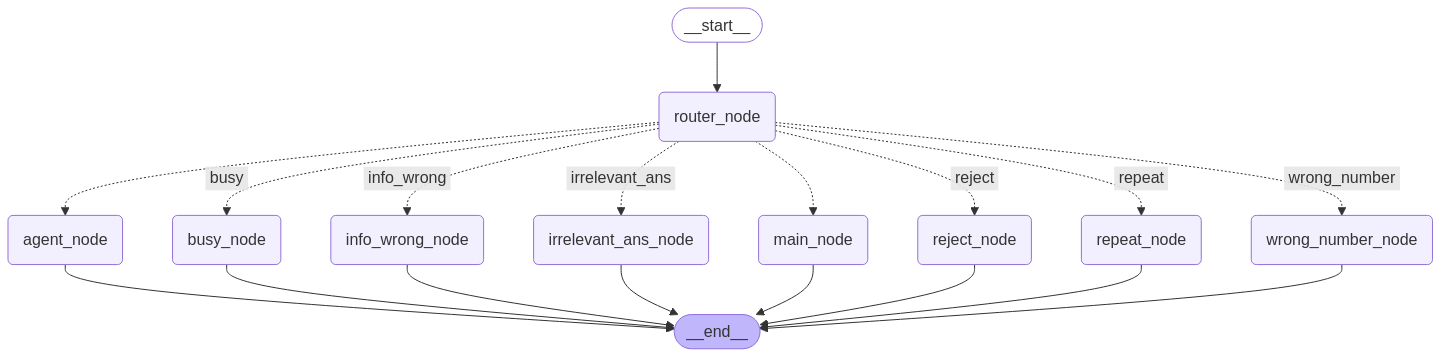

In [ ]:
class HumanBotQuery(BaseModel):
    session_id: str
    user_text: str
    bot_query: Optional[str] = None
    language: Literal['en-IN', 'hi-IN']

user_chat_histories = TTLCache(maxsize=1500, ttl=100)

def get_user_chat_history(session_id: str) -> ChatMessageHistory:
    if session_id not in user_chat_histories:
        user_chat_histories[session_id] = ChatMessageHistory()
    return user_chat_histories[session_id]

Language_map = {'en-IN': 'English', 'hi-IN': 'Hindi'}

def handle_user_request(request: HumanBotQuery):
    try:
        chat_history = get_user_chat_history(request.session_id)
        chat_history.add_user_message(request.user_text)

        context = {
            "Name": "ALPHA",
            "interest_rate": "8.9",
            "tenure": "36",
            "amount": "7000000"
        }

        config = {"configurable": {"thread_id": request.session_id}}

        # Initialize language from request
        language = Language_map.get(request.language, "English")

        initial_state = {
            "messages": list(chat_history.messages),
            "user_text": request.user_text,
            "context": context,
            "language": language,
            "today_date": str(date.today()),
            "number_conversation": 1,
            "busy_counter": 0,
            "refusal_counter": 0,
            "decision": "",
            "output": "",
            "status": "continue"
        }

        response = workflow.invoke(initial_state)

        # Update language based on response
        return_language = "en-IN" if response["language"] == "English" else "hi-IN"

        # Update chat history
        chat_history.add_ai_message(response["output"])

        return {'bot_response': response["output"], "status": response["status"], "language": return_language}

    except Exception as e:
        message = {
            "error": str(e),
            "text": "An exception raised while handling conversation.",
            "status_code": 500
        }
        return message

# Example usage
bot_query = """Dear Customer, I am calling on behalf of Tata Capital. You've been shortlisted for a preapproved personal loan. Do you want to know more details?"""
session_id = str(uuid.uuid4())
questions = ["मैं लोन लेना चाहते हूँ"]

for question in questions:
    st = time.time()
    request = HumanBotQuery(session_id=session_id, bot_query=bot_query, user_text=question, language='hi-IN')
    print(f"-> *Questions* {question} \n")
    response = handle_user_request(request)
    print(f"-> *Response* {response} \n")
    print("time to took respond : ", time.time()-st)